c:\Users\ABC\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


(59, 59)
(59, 59)
(59, 1)
(59, 1)
(59, 1)
(59, 1)
(59, 59)
(59, 1)
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
A01: Products of agriculture, hunting and related services
A02: Products of forestry, logging and related services
A03: Fish and other fishing products; aquaculture products; support services to fishing
B: Mining and quarrying
C10T12: Food products, beverages and tobacco products
C13T15: Textiles, wearing apparel and leather products
C16: Wood and of products of wood and cork, except furniture; articles of straw and plaiting materials
C17: Paper and paper products
C18: Printing and recording services
C19: Coke and refined petroleum products 
C20-21: Chemicals and chemical products AND Basic pharmaceutical products and pharmaceutical preparations
C22: Rubber and plastics products
C23: Other non-metallic mineral products
C24: Basic metals
C2

c:\Users\ABC\OneDrive\Skrivbord\Code\RHP HERE\rhp\simulations for viewing\Sweden\../../../rhp\rhp_plan.py:91: OptimizeWarning: Unknown solver options: tol
  result = optimize.linprog(c=aggregate_primary_resource_vector,
c:\Users\ABC\OneDrive\Skrivbord\Code\RHP HERE\rhp\simulations for viewing\Sweden\../../../rhp\rhp_plan.py:97: OptimizeWarning: Unknown solver options: tol
  lagrange_ineq = -optimize.linprog(c=aggregate_primary_resource_vector,


True
0
True
0


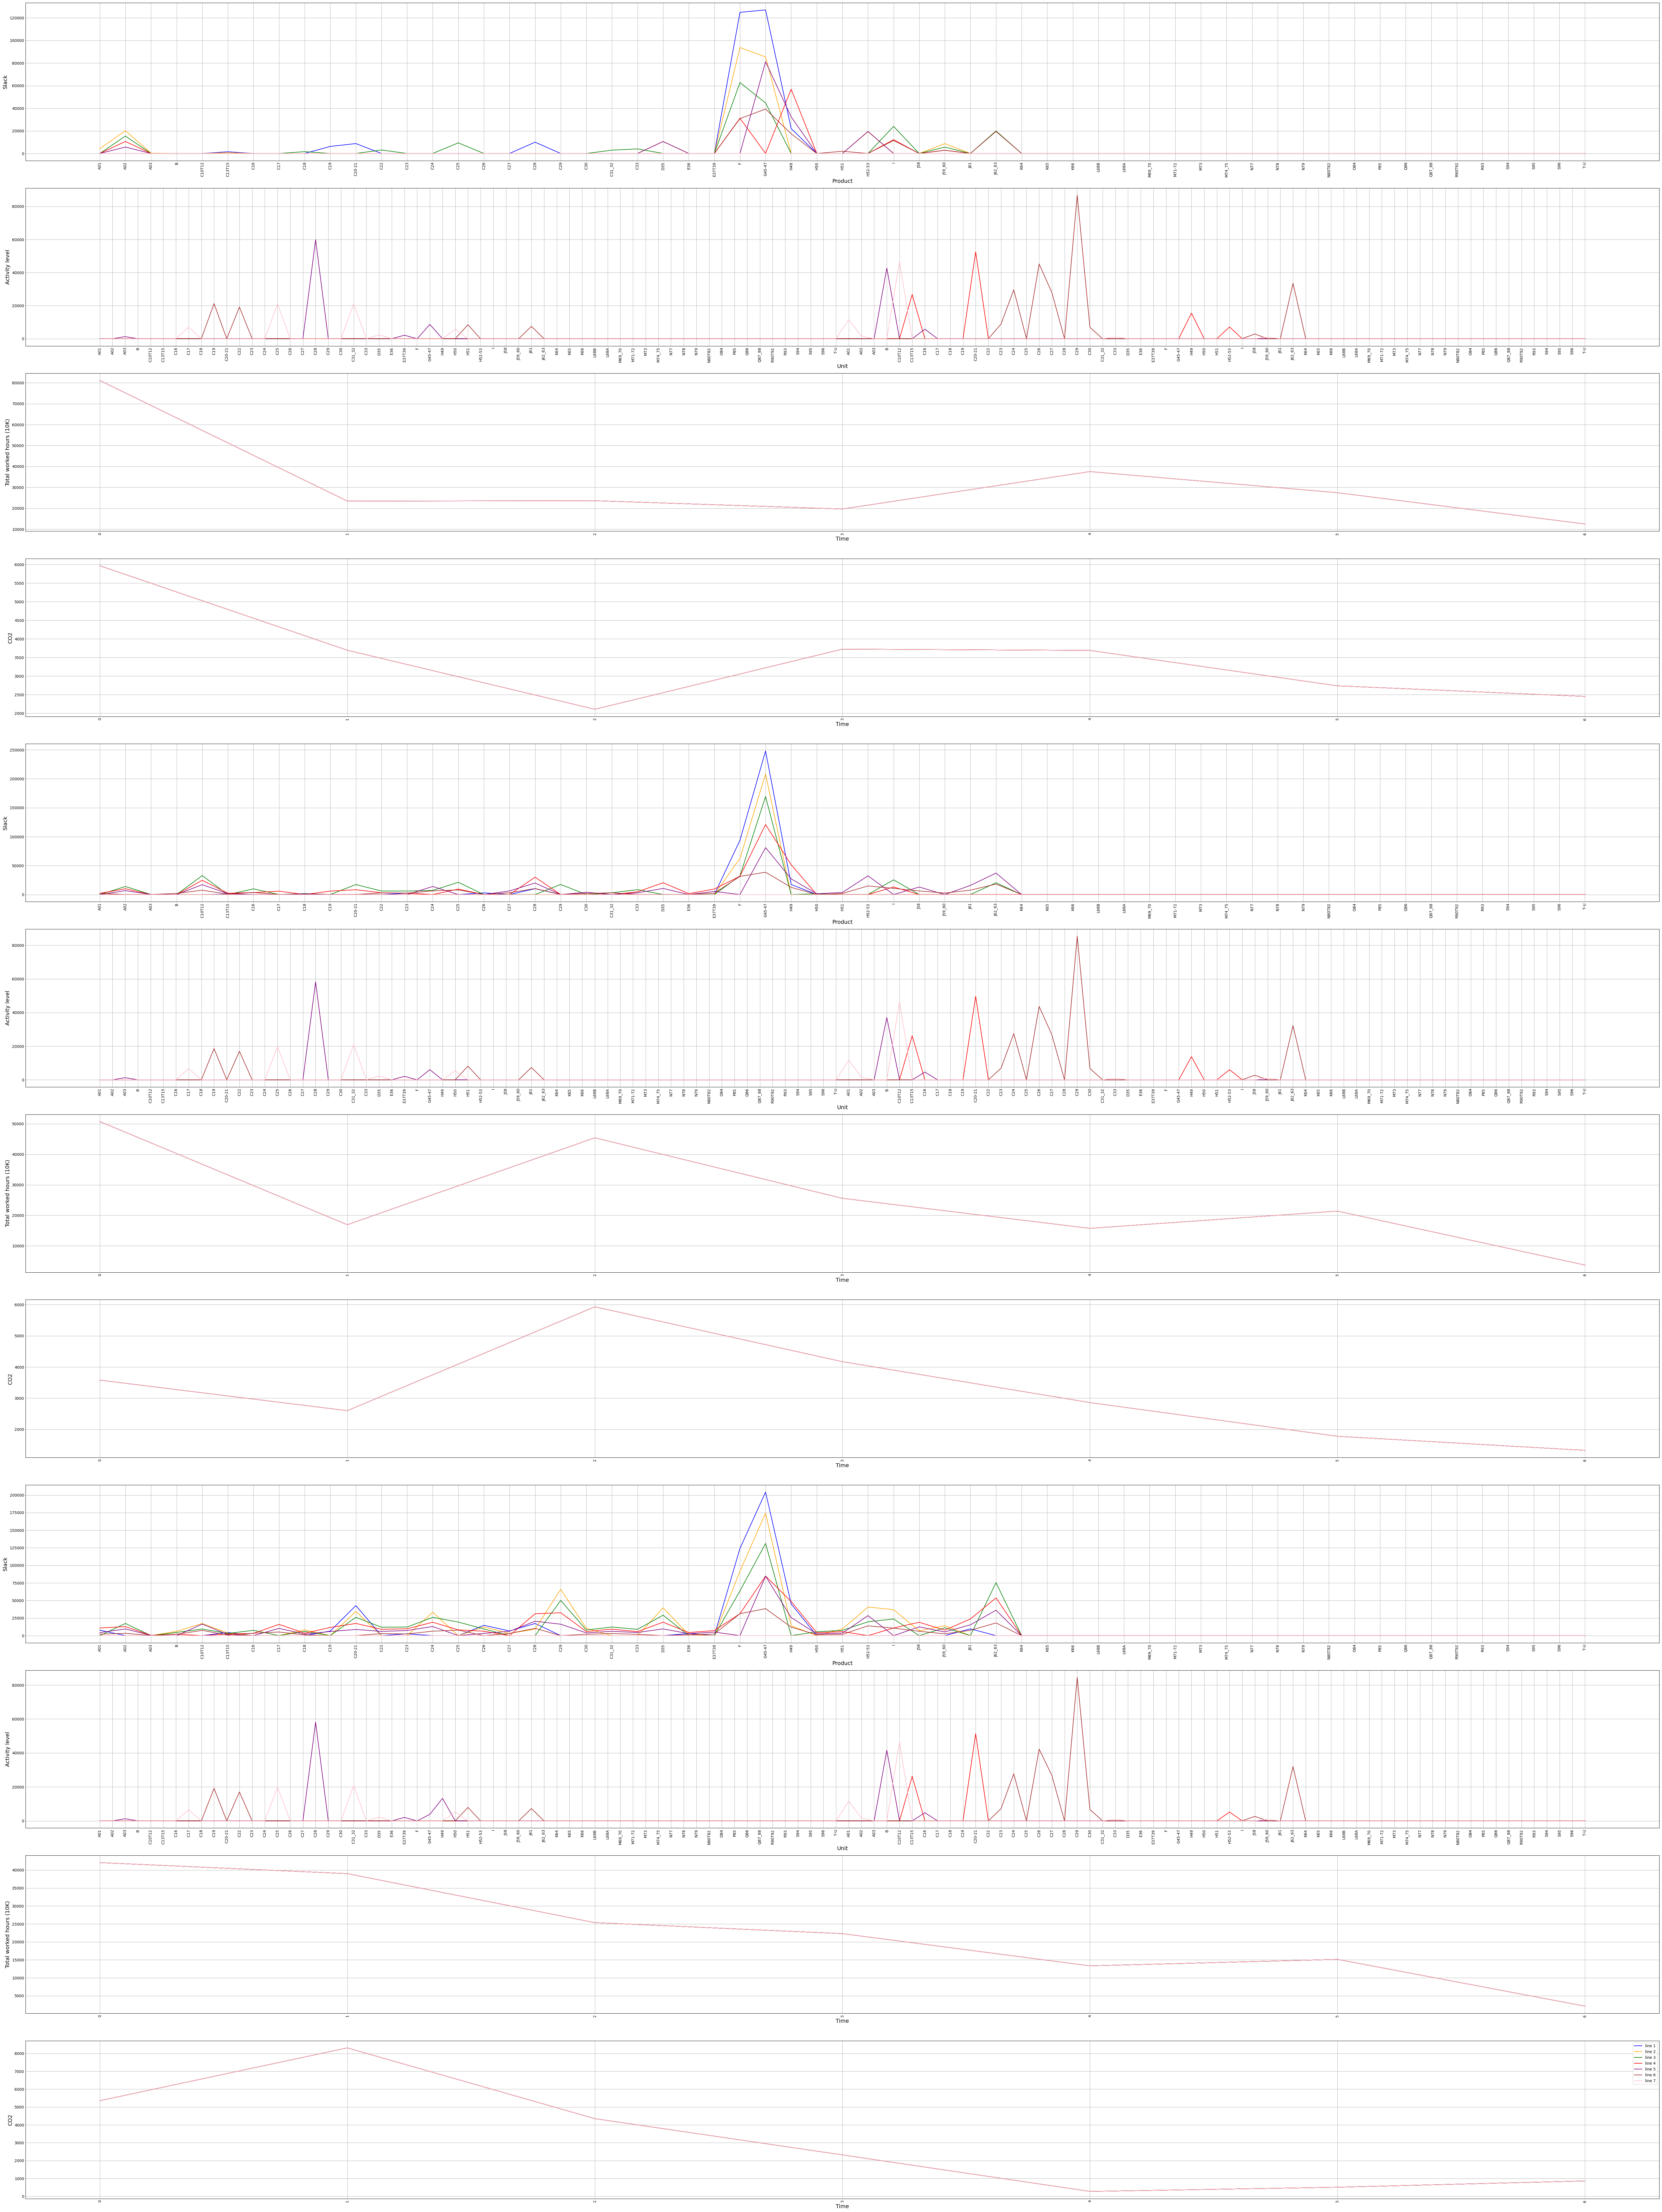

In [1]:
import sys 
sys.path.append("../../../rhp")
from rhp_plan import plan
from pathlib import Path
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from copy import deepcopy

#Description: each timestep is a month and have 2016's target output rescaled by (1/12) 
# with rescaled industries for some month (A01 2 and 3 are halved during month 2 in this case)
# here financial industries are zeroed out: K and forward

#Last ran with Python 3.10.6 and current requirements

#Excel information extraction
xlsx_file = Path('rescaled2.xlsx')
main_sheet = openpyxl.load_workbook(xlsx_file)['2016']
xlsx_file = Path('posternas_namn.xlsx')
shorthand_sheet = openpyxl.load_workbook(xlsx_file)['SUP10']

#Division with zero-exception
def zdivide(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

#List constructor
def matrix_list_maker(to_matrix, list_length):
    return [np.matrix(to_matrix)] * list_length

# Generates a 2D list of values from a xlsx file, reading left to right, top to bottom.
class Sheet:
    def __init__(self, sheet, left: int, top: int, right: int, bottom: int):
        result_sheet = []
        coordinates = []

        for row in sheet.iter_rows(min_row=left, min_col=top, max_row=right, max_col=bottom):
            data = []
            pos = []

            for cell in row:
                data.append(cell.value)
                pos.append(cell)

            result_sheet.append(data)
            coordinates.append(pos)

        self.result = result_sheet
        self.coordinates = coordinates

    @property
    def np_array(self):
        return np.array(self.result, dtype=np.float64)

#Input values and list construction
time_steps = 3
planning_horizon = 6
step_horizon = time_steps + planning_horizon + 1

use_domestic = Sheet(main_sheet, 4, 3, 62, 61).np_array
supply = Sheet(main_sheet, 159, 3, 217, 61).np_array
supply_use = supply - use_domestic

use_imported = Sheet(main_sheet, 94, 3, 152, 61).np_array

domestic_export_target_output = Sheet(main_sheet, 4, 75, 62, 75).np_array*(1/12)
imported_export_target_output = Sheet(main_sheet, 94, 75, 152, 75).np_array*(1/12)

imported_target_output = (Sheet(main_sheet, 94, 77, 152, 77).np_array.reshape([-1,1]))*(1/12)
full_domestic_target_output = np.array(np.sum(supply_use, axis=0)).reshape([-1,1])*(1/12)
export_prices = deepcopy(Sheet(main_sheet, 4, 77, 62, 77).np_array) 
import_prices = deepcopy(Sheet(main_sheet, 4, 77, 62, 77).np_array) 
depreciation = np.array(np.eye(N=supply.shape[0], M=supply.shape[0], k=0)) 
worked_hours = Sheet(main_sheet, 86, 3, 86, 61).np_array.reshape([-1,1])
co2 = Sheet(main_sheet, 87, 3, 87, 61).np_array

supply_use_list = matrix_list_maker(supply_use, step_horizon)
full_domestic_target_output_list = matrix_list_maker(full_domestic_target_output, step_horizon)
imported_target_output_list = matrix_list_maker(imported_target_output, step_horizon)
domestic_export_target_output_list = matrix_list_maker(domestic_export_target_output, step_horizon)
imported_export_target_output_list = matrix_list_maker(imported_export_target_output, step_horizon)
use_imported_list = matrix_list_maker(use_imported, step_horizon)

export_prices_list = matrix_list_maker(export_prices, step_horizon)
import_prices_list = matrix_list_maker(import_prices, step_horizon)
depreciation_list = matrix_list_maker(depreciation, step_horizon)
primary_resource_list = matrix_list_maker(worked_hours, step_horizon)

export_constraint_boolean = True

#Turning down agriculture at month designated by down_time
down_time = 1
supply_agriculture_off = Sheet(main_sheet, 4, 80, 62, 138).np_array
use_domestic_agriculture_off = Sheet(main_sheet, 94, 80, 152, 138).np_array
supply_use_list[down_time] = deepcopy(np.matrix(supply_agriculture_off - use_domestic_agriculture_off))

# Logging
print(supply_use_list[0].shape)
print(use_imported_list[0].shape)
print(full_domestic_target_output_list[0].shape)
print(imported_target_output_list[0].shape)
print(export_prices_list[0].shape)
print(import_prices_list[0].shape)
print(depreciation_list[0].shape)
print(primary_resource_list[0].shape)

print(type(supply_use_list[0]))
print(type(use_imported_list[0]))
print(type(full_domestic_target_output_list[0]))
print(type(imported_target_output_list[0]))
print(type(export_prices_list[0]))
print(type(import_prices_list[0]))
print(type(depreciation_list[0]))
print(type(primary_resource_list[0]))

shorthand = [[x[0][4:] if x[0].startswith('CPA_') else x[0], x[1]] for x in Sheet(shorthand_sheet, 7, 2, 65, 3).result]
[print(f'{short}: {desc}') for short, desc in shorthand]

# Sector & Notation
sector = Sheet(main_sheet, 3, 3, 3, 61)
sector_name_input = deepcopy(sector.result[0])
sector_with_all_outputs_input = deepcopy(sector_name_input)
double_notation = deepcopy(sector_with_all_outputs_input+sector_with_all_outputs_input)
notation = deepcopy(sector_with_all_outputs_input)

# Plan
plan_outcome = plan(time_steps=time_steps,
                    planning_horizon=planning_horizon,
                    primary_resource_list=primary_resource_list,
                    supply_use_list=supply_use_list,
                    use_imported_list=use_imported_list,
                    depreciation_list=depreciation_list,
                    full_domestic_target_output_list=full_domestic_target_output_list, 
                    imported_target_output_list=imported_target_output_list, 
                    export_constraint_boolean=export_constraint_boolean, 
                    export_prices_list=export_prices_list,
                    import_prices_list=import_prices_list,
                    upper_bound_on_activity = None, # Max upper bound for non-export constraint: 19
                    max_iterations=1000, # Max iterations: 10e+10
                    tolerance=10e-8) # Max tolerance: 10e-8

# Plan details
result_list = plan_outcome[0]
lagrange_list = plan_outcome[1]
slack_list = plan_outcome[2]
optimization_primary_resource_vector = plan_outcome[3]
optimization_supply_use = plan_outcome[4]
optimization_target_output = plan_outcome[5]

# Plot configurations
plt.style.use('_mpl-gallery')
fig = plt.figure(figsize=(60, 480)) #Width and height scale config
number_of_graphs = 4
gs = gridspec.GridSpec(number_of_graphs * time_steps * planning_horizon, 1)

labels = ['Slack',
          'Activity level',
          'Lagrange multiplier',
          'Worked hours (10K)',
          'CO2',
          'Total worked hours (10K)']

splitting_size_row = deepcopy(planning_horizon+1)
splitting_size_column = deepcopy(planning_horizon+1)

if export_constraint_boolean:
    splitting_size_row = deepcopy(planning_horizon+2)
    splitting_size_column = deepcopy(planning_horizon*2+2)
    notation = double_notation

#Define a list colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(time_steps):
    ax = fig.add_subplot(gs[i * number_of_graphs + 1, 0])
    ax.set_xlabel('Product', fontsize=14)
    ax.set_ylabel(labels[0], fontsize=14)
    
    #Set the locations and labels for the x-axis ticks
    x_ticks = np.arange(0, len(sector_with_all_outputs_input), 1)
    x_tick_labels = sector_with_all_outputs_input[::1]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    ax.tick_params(axis='x', labelrotation=90)

    for j in range(planning_horizon+1):
        s = np.array_split(slack_list[i], splitting_size_row)
        ax.plot(range(s[j].shape[0]), s[j], color=colors[j])

    ax = fig.add_subplot(gs[i * number_of_graphs + 2, 0])
    ax.set_xlabel('Unit', fontsize=14)
    ax.set_ylabel(labels[1], fontsize=14)
    
    #Set the locations and labels for the x-axis ticks
    x_ticks = np.arange(0, len(notation), 1)
    x_tick_labels = notation[::1]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    ax.tick_params(axis='x', labelrotation=90)

    for j in range(planning_horizon+1):
        x = np.array_split(result_list[i], planning_horizon+1)
        ax.plot(range(x[j].shape[0]), x[j], color=colors[j])

    resulting_worked_hours = [] 
    x = np.array_split(result_list[i], splitting_size_column)

    for j in range(planning_horizon+1):
        resulting_worked_hours.append((np.matmul(worked_hours.reshape([1,-1]), x[j]).item(0)))
    ax = fig.add_subplot(gs[i * number_of_graphs + 3, 0])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(labels[5], fontsize=14)
    ax.tick_params(axis='x', labelrotation=90)

    for j in range(planning_horizon+1):
        ax.plot(range(planning_horizon+1), resulting_worked_hours, color=colors[j])

    resulting_co2 = [] 
    x = np.array_split(result_list[i], splitting_size_column)
    for j in range(planning_horizon+1):
        resulting_co2.append(np.matmul(co2, x[j]).item(0))

    ax = fig.add_subplot(gs[i * number_of_graphs + 4, 0])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(labels[4], fontsize=14)
    ax.tick_params(axis='x', labelrotation=90)
    for j in range(planning_horizon+1):
        ax.plot(range(planning_horizon+1), resulting_co2, color=colors[j])

plt.legend(labels=['line ' + str(j+1) for j in range(planning_horizon+1)], loc='best')
plt.tight_layout()
plt.show()


